In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

2024-11-27 10:03:43.075104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 10:03:43.077188: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 10:03:43.079593: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-27 10:03:43.086475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732698223.098183   23921 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732698223.10

In [2]:
IMAGE_WIDTH = 220
IMAGE_HEIGHT = 229
BATCH_SIZE = 10

base_path = "data/head_ct"

In [3]:
labels = pd.read_csv("data/labels.csv", index_col="id")

In [4]:
labels.loc[142, ' hemorrhage']

np.int64(0)

In [5]:
files = sorted(os.listdir(path=base_path))
normal_imgs = [fn for i, fn in enumerate(files) if (labels.loc[i, ' hemorrhage'] == 0)]
hemorrhage_imgs = [fn for i, fn in enumerate(files) if (labels.loc[i, ' hemorrhage'] == 1)]
print(f'Num. normal: {len(normal_imgs)}, num. hemorrhage: {len(hemorrhage_imgs)}')

Num. normal: 100, num. hemorrhage: 100


In [6]:
normal_selection = np.random.choice(normal_imgs, 5, replace = False)
hemorrhage_selection = np.random.choice(hemorrhage_imgs, 5, replace = False)

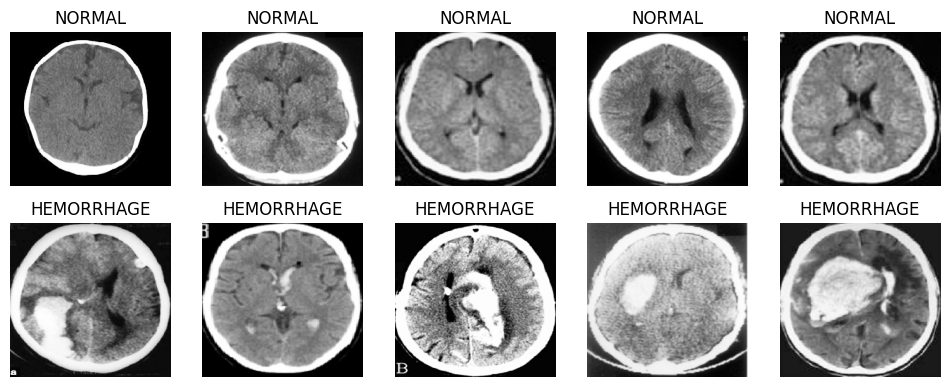

In [7]:
fig = plt.figure(figsize=(12, 12)) 
for i in range(10):
    if i < 5:
        fp = f'data/head_ct/{normal_selection[i]}'
        label = 'NORMAL'
    else:
        fp = f'data/head_ct/{hemorrhage_selection[i-6]}'
        label = 'HEMORRHAGE'
    ax = fig.add_subplot(5, 5, i+1)
    
    # to plot without rescaling, remove target_size
    fn = image.load_img(fp, target_size = (IMAGE_WIDTH,IMAGE_HEIGHT), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

In [8]:
def img2np(path, list_of_filename, size=(IMAGE_WIDTH, IMAGE_HEIGHT)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

normal = img2np('data/head_ct/', normal_imgs)
hemorrhage = img2np('data/head_ct/', hemorrhage_imgs)

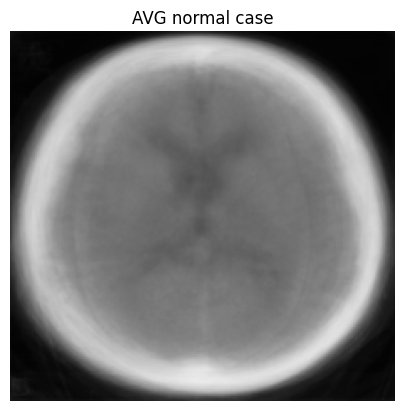

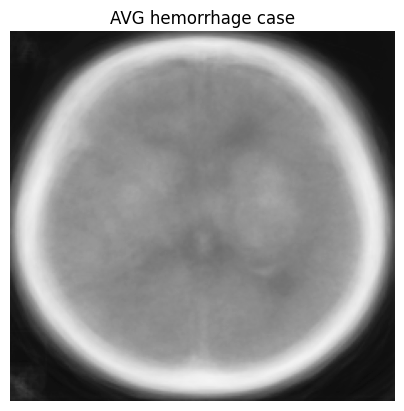

In [9]:
def find_mean_img(full_mat, title, size=(IMAGE_WIDTH, IMAGE_HEIGHT)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'AVG {title} case')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean_img = find_mean_img(normal, 'normal')
hemorrhage_mean_img = find_mean_img(hemorrhage, 'hemorrhage')

-------------------------------------------------------------

In [10]:
def load_image_and_label(image_name, label):
    img_path = tf.strings.join([base_path, image_name], separator="/")
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [128, 128])
    img = img / 255.0
    return img, label

In [11]:
normal_labels = [0] * len(normal_imgs)
normal_dataset = tf.data.Dataset.from_tensor_slices((normal_imgs, normal_labels))
normal_dataset = normal_dataset.map(load_image_and_label)

2024-11-27 10:03:45.968057: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
hemorrhage_labels = [1] * len(hemorrhage_imgs)
hemorrhage_dataset = tf.data.Dataset.from_tensor_slices((hemorrhage_imgs, hemorrhage_labels))
hemorrhage_dataset = hemorrhage_dataset.map(load_image_and_label)

In [13]:
full_dataset = normal_dataset.concatenate(hemorrhage_dataset)
full_dataset = full_dataset.shuffle(buffer_size=len(full_dataset))

train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset = full_dataset.take(train_size).batch(BATCH_SIZE)
val_dataset = full_dataset.skip(train_size).take(val_size).batch(BATCH_SIZE)
test_dataset = full_dataset.skip(train_size).skip(val_size).batch(BATCH_SIZE)

In [14]:
input_shape = None
for batch, labels in train_dataset.take(1):
    input_shape = batch.shape
    print(input_shape)
    print(labels.numpy())

(10, 128, 128, 3)
[1 0 1 1 1 1 0 0 1 0]


2024-11-27 10:03:46.278060: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


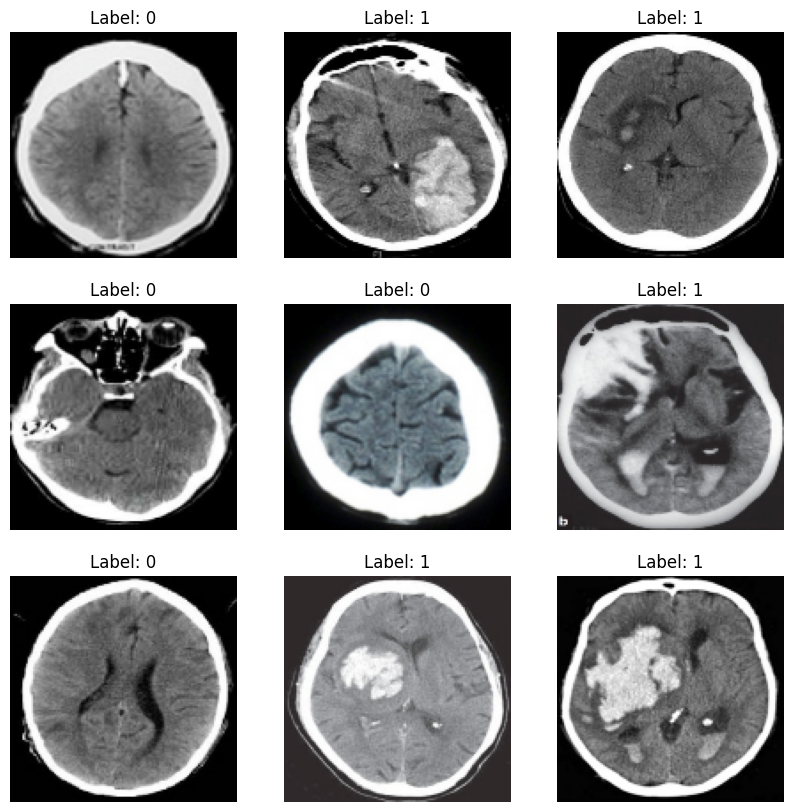

2024-11-27 10:03:46.866701: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
for img, label in train_dataset.take(1):  # Vezmeme prvý batch
    plt.figure(figsize=(10, 10))
    for i in range(min(9, img.shape[0])):  # Ukážeme maximálne 9 obrázkov
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[i])  # Zobrazíme obrázok
        plt.title(f"Label: {label[i].numpy()}")
        plt.axis("off")
    plt.show()

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binárna klasifikácia
])

/mnt/1847ADF2212734FB/vysoka_skola/3_rocnik/1_semester/IAU/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.4004 - loss: 0.6932 - val_accuracy: 0.4500 - val_loss: 0.6932
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5584 - loss: 0.6928 - val_accuracy: 0.4250 - val_loss: 0.6934
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5447 - loss: 0.6917 - val_accuracy: 0.3750 - val_loss: 0.6955
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.5277 - loss: 0.6918 - val_accuracy: 0.7500 - val_loss: 0.6891
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.6902 - loss: 0.6894 - val_accuracy: 0.4500 - val_loss: 0.6916
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.4765 - loss: 0.6922 - val_accuracy: 0.6500 - val_loss: 0.6863
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5642 - loss: 0.6889 - val_accuracy: 0.5250 - val_loss: 0.6857
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.6442 - loss: 0.6831 - val_accuracy: 0.6000 - 

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)
test_acc

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6000 - loss: 0.6290 


0.6000000238418579

In [20]:
train_loss, train_acc = model.evaluate(train_dataset)
train_acc

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6051 - loss: 0.6033


0.5928571224212646